In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurd
from mesh_tools import trimesh_utils as tu
from datasci_tools import ipyvolume_utils as ipvu
from neurd import neuron_visualizations as nviz
from pathlib import Path
import os
import inspect
print(inspect.getfile(tu))


/usr/local/lib/python3.8/dist-packages/python_jsonschema_objects/__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


/usr/local/lib/python3.8/dist-packages/mesh_tools/trimesh_utils.py


Use MeshParty to Upload ChenLab Data 

In [3]:
#  ChenLab script to load mesh...

from meshparty import trimesh_io  # for grabbing a mesh
from meshparty import trimesh_vtk  # for visualizing meshes and skeletons
    
# provide the DENDRITIC segmentation ID for the cell of interest
dend_id = 74875092987018534 # 75507999300732200 #75507999300732200 # 75226661762888530 #75226730549251974 #75508068086991145 # 74945255505716070 # 74945461596862189 

# Get the DENDRITIC segmentation mesh from neuroglancer
mm = trimesh_io.MeshMeta(
        cv_path="precomputed://gs://zetta_jchen_mouse_cortex_001_segmentation/cell/lowres/240820_emb24_lowres_x1/seg", 
        map_gs_to_https=True)

mesh = mm.mesh(seg_id=dend_id) 

# visualize the mesh
mesh_actor = trimesh_vtk.mesh_actor(mesh,  color=(1,0,0),  opacity=0.25)
#trimesh_vtk.render_actors([mesh_actor]) #NOTE: need to close the window when done to unpause python

# store the mesh
# Define the local file path where you want to save the mesh (with .off extension)
local_file_path = "32414.off"
# Export the mesh to a .off file
mesh.export(local_file_path)
# Confirm the file has been saved
print(f"Mesh has been saved to {os.path.abspath(local_file_path)}")


#import skeletor as sk
# pre-process the mesh (may not be necessary)
#mesh_fix = sk.pre.fix_mesh(mesh) #
#mesh_fix_actor = trimesh_vtk.mesh_actor(mesh_fix,  color=(1,0,0),  opacity=0.25)
#trimesh_vtk.render_actors([mesh_actor, mesh_fix_actor]) 



Mesh has been saved to /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/32414.off


# Load the appropriate volume data inferface object

In [4]:
from neurd.vdi_microns import volume_data_interface as vdi
vdi.set_parameters_for_directory_modules()

# Data Prep: Loading mesh

In [63]:
# run this segment if we want BCM data

segment_id = 864691134917511946 # BCM
synapse_filepath = str(Path(f'./{segment_id}_synapses.csv').absolute())
synapse_filepath

from datasci_tools import pandas_utils as pu
df = pu.csv_to_df(synapse_filepath)
df

vdi.set_synapse_filepath(
    synapse_filepath
)

mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(420741, 3), faces.shape=(865980, 3), name=`864691134917511946.off`)>

In [5]:
# ChenLab MESH
# run this cell only if we want to use chenlab mesh
segment_id = 32414
mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

/usr/local/lib/python3.8/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(178983, 3), faces.shape=(358086, 3), name=`32414.off`)>

In [6]:
from datasci_tools import pipeline

products = pipeline.PipelineProducts()
products

# Step 1: Decimation

In [7]:
"""
NOTE: an already decimated mesh is used for the example
in order to speed up time, that's why the mesh_dec
object will be overwritten with original mesh object
"""

"\nNOTE: an already decimated mesh is used for the example\nin order to speed up time, that's why the mesh_dec\nobject will be overwritten with original mesh object\n"

In [8]:
decimation_parameters = dict(
    decimation_ratio =0.25,
)

In [9]:
import time

# tu

st = time.time()
mesh_decimated = tu.decimate(
    mesh,
    **decimation_parameters
)

print(f"Total time = {time.time() - st}")

xvfb-run -n 9331 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_88728.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_88728_decimated.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/decimation_meshlab_25593192.mls
Total time = 11.239309310913086


In [10]:
# saving any parameters used or output products for later use
products.set_stage_attrs(
    stage = "decimation",
    attr_dict = dict(
        decimation_parameters = decimation_parameters,
        segment_id = segment_id,
    ),
    
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':32414,
  },
}



# Step 2: Soma Identification

In [11]:
from neurd import soma_extraction_utils as sm
soma_extraction_parameters = dict()

In [12]:
# could inspect the parameters of a certain category
from neurd import parameter_utils as paru
paru.category_param_from_module(
        module = sm,
        category = "glia",
)

{'glia_volume_threshold_in_um_global': 2500,
 'glia_n_faces_threshold_global': 400000,
 'glia_n_faces_min_global': 100000}

In [13]:
# overwritting decimated mesh because original was already decimated
mesh_decimated = mesh

In [14]:
from neurd import neuron_visualizations as nviz

verbose = True

soma_products = sm.soma_indentification(
    mesh_decimated,
    verbose=verbose,
    **soma_extraction_parameters
)

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 5000.0 
large_mesh_threshold_inner = 3250.0 
soma_size_threshold = 562.5 
soma_size_threshold_max = 75000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
max_mesh_sized_filtered_away = 22500.0
xvfb-run -n 3859 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_40432.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_40432_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_451474.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_40432.off
removed temporary output file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_40432_remove_interior.off
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_S

  0%|          | 0/13 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.8086720000000001]
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 2678 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_511616.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_511616_poisson.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_527688.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_511616.off
removed temporary output file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_511616_poisson.off
mesh.is_watertight = True
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_527688.mls is being deleted....
Inside sphere validater: ratio_val = 2.53

  0%|          | 0/6 [00:00<?, ?it/s]


    --- On segmentation loop 1 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(144, 3), faces.shape=(282, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(144, 3), faces.shape=(282, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 2



  0%|          | 0/2 [00:00<?, ?it/s]


    --- On segmentation loop 2 --
largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(95, 3), faces.shape=(184, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>

largest_mesh_path_inner_decimated_clean = <trimesh.Trimesh(vertices.shape=(95, 3), faces.shape=(184, 3), name=`neuron_12345_decimated_largest_piece_poisson_largest_inner_decimated.off`)>
soma_size_threshold = 562.5
soma_size_threshold_max = 75000.0
soma_width_threshold = 0.32

Number of segments: 1



  0%|          | 0/1 [00:00<?, ?it/s]




 Total time for run = 72.30012440681458
Before Filtering the number of somas found = 1

---Performing Soma Mesh Backtracking to original mesh for poisson soma 0
backtrack_soma_size_threshold = 8000
xvfb-run -n 9758 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_78638.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_78638_fill_holes.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/fill_holes_66561.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_78638.off
removed temporary output file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_78638_fill_holes.off
/NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/fill_holes_66561.mls is being deleted....
xvfb-run -n 2675 -s "-screen 0 800x600x24

  0%|          | 0/3 [00:00<?, ?it/s]

Largest hole before segmentation = 247379.7917391773, after = 704814.3360077644,

ratio = 2.849118479131388, difference = 457434.54426858714
filtered_soma_list_components = [<trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>]
Not need to do a second pass because already found a soma


In [15]:
sm.plot_soma_products(
    mesh_decimated,
    soma_products = soma_products,
    verbose = True
)

# of somas = 1
# of glia = 0
# of nuclei = 4


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [16]:
soma_products.soma_extraction_parameters = soma_extraction_parameters
soma_products

In [17]:
products.set_stage_attrs(
    stage = "soma_identification",
    attr_dict = soma_products,
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':32414,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(54, 3), faces.shape=(18, 3))>, <trimesh.Trimesh(vertices.shape=(4, 3), faces.shape=(2, 3))>, <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>, <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>],
    'soma_extraction_parameters':
    {
    },
    'soma_meshes':[<trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>],
    'soma_run_time':72.30012321472168,
    'soma_sdfs':array([0.808672]),
  },
}



# Step 2b: Saving off pipeline products

In [18]:
from datasci_tools import system_utils as su
su.save_object(
    products,"products_up_to_soma_stage"
)

Saved object at /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/products_up_to_soma_stage.pkl
File size is 23.122054 MB
Cleared mesh: <trimesh.Trimesh(vertices.shape=(54, 3), faces.shape=(18, 3))>:140207185663072
Cleared mesh: <trimesh.Trimesh(vertices.shape=(4, 3), faces.shape=(2, 3))>:140207185665904
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>:140207412124640
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>:140207412115248
Cleared mesh: <trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>:140207419619120


# Step 3: Decomposition

In [19]:
import networkx as nx
nx.__version__

'2.8.8'

In [20]:
from neurd import neuron

neuron_obj = neuron.Neuron(
    mesh = mesh,
    segment_id = segment_id, # don't need this explicitely if segment_id is already in products
    pipeline_products = products,
    suppress_preprocessing_print=False,
    suppress_output=False,
)

neuron_obj

--- 0) Having to preprocess the Neuron becuase no preprocessed data
Please wait this could take a while.....
Skipping the hole filling
limb_remove_mesh_interior_face_threshold = 0
use_meshafterparty = True
Using pre-computed somas: soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>]
Soma List = [<trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>]
soma_mesh_list_centers = [array([1220566.63643579, 1217419.06988471,  146685.22361465])]
Getting Glia and Nuclei Pieces Subtracted Away 0.0848841667175293
 Splitting mesh after soma cancellation 0.33411455154418945
# of split_meshes = 20
 Containing Mesh Indices 0.01713252067565918
containing_mesh_indices = {0: 0}
 non_soma_touching_meshes 1.8358230590820312e-05
There were 19 pieces found after size threshold
 Finding inside pieces and non_soma_touching meshes 1.7110636234283447
soma_containing_meshes = {0: [0]}

-----Before combining multiple mesh pieces-----
soma_containing_meshes = {0: [

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/48865 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.8715338706970215
connecting at the root
branches_touching_root = [12]
combining close nodes
combine_threshold = 700
length of Graph = 3148
After combining close endpoints max(kept_branches_idx) = 12, len(kept_branches_idx) = 13
empty_indices % = 0.0
 conflict_indices % = 0.009269300812342698


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Decomposing first pass: 5.678959369659424
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [18820, 4940, 8725, 4159, 6462, 5558, 3101, 4089, 9111, 10326, 15125]
mesh_large_connectivity: 0.14967632293701172
Finding MAP candidates connected components: 0.00017571449279785156
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.030285120010375977
Grouping MP Sublimbs by Graph: 0.005333662033081055
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0037043094635009766
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 6187 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.06426286697387695
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 56.46936249732971
Checking connected components after removing cycles
Total time for mesh KDTree = 0.6300938129425049
sbv[0].reshape(-1,3) = [[1222503.375    1220426.5       138108.140625]]
closest_sk_pt_coord BEFORE = [1221900. 1220090.  137099.]
current_skeleton.shape = (2062, 2, 3)
node_for_stitch = 209: [1221900. 1220090.  137099.]
node_for_stitch AFTER = 209: [1221900. 1220090.  137099.]
possible_node_loc = [   0   85  209  281  296  344  431  444  540  612  690  742  810  812
  818 1155 1277 1609 1907 1910 1940 2062]
possible_node_loc AFTER = [   0   85  209  281  296  344  431  444  540  612  690  742  810  812
  818 1155 1277 1609 1907 1910 1940 2062]
curr_shortest_path = [209]
Current stitch point was a branch or endpoint
change_status for create soma ext

  0%|          | 0/14 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (2013, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 61.787800788879395
Working on limb correspondence for #0 MAP piece
xvfb-run -n 7440 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_307.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_307_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_699850.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_307.off
removed temporary output file: /NEURD_Chenlab/Applicati

0it [00:00, ?it/s]

Total time for decomposition = 12.103556394577026
mesh_correspondence_first_pass: 12.103603601455688
Limb decomposed into 15 branches
divided_skeleton_graph_recovered = (2013, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (2013, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (14, 15)
empty_indices % = 0.027196513891346665
 conflict_indices % = 0.028866572288090604


  0%|          | 0/72 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 80.82598233222961
correspondence_1_to_1: 6.930814027786255
Total time for MAP sublimb processing 80.82614517211914
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.001363992691040039
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0005848407745361328
Do Not Need to Fix MP Decomposition 1 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
sk_conn = [0]
conn = [0]
winning_vertex = [1261948.19436693 1243717.16375087   92908.54998616]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [10]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.0030482443285069463
 conflict_indices % = 0.003224104578228501


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.013319571414528655
 conflict_indices % = 0.022461417477636882


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
sk_conn = [0]
conn = [0]
winning_vertex = [1262597.73845702 1219225.09958902  100842.32240148]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.027158001009591117
 conflict_indices % = 0.008480565371024734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04962707974756168
 conflict_indices % = 0.028757888697647734


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 



Time for decomp of Limb = 95.85705757141113
Number of matching vertices = 72
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/19 [00:00<?, ?it/s]

97741 97742
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 1 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1224300.      1223147.625    148375.15625]
Time for preparing soma vertices and root: 0.0008091926574707031
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/47801 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.7258617877960205
connecting at the root
branches_touching_root = [10]
combining close nodes
combine_threshold = 700
length of Graph = 2806
After combining close endpoints max(kept_branches_idx) = 10, len(kept_branches_idx) = 11
empty_indices % = 0.0
 conflict_indices % = 0.00842252843257269


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Decomposing first pass: 5.002007961273193
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [15236, 3682, 8408, 7850, 4047, 13339, 8949, 4142, 17597]
mesh_large_connectivity: 0.11436653137207031
Finding MAP candidates connected components: 0.0001800060272216797
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.03336310386657715
Grouping MP Sublimbs by Graph: 0.0076029300689697266
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.005343198776245117
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 8468 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None_poisson.off 

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.06296992301940918
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 55.70793700218201
Checking connected components after removing cycles
Total time for mesh KDTree = 0.5769975185394287
sbv[0].reshape(-1,3) = [[1224300.      1223147.625    148375.15625]]
closest_sk_pt_coord BEFORE = [1223560. 1223910.  149784.]
current_skeleton.shape = (1774, 2, 3)
node_for_stitch = 1047: [1223560. 1223910.  149784.]
node_for_stitch AFTER = 1047: [1223560. 1223910.  149784.]
possible_node_loc = [   0   64   75  166  292  334  337  559  611  628 1047 1411 1613 1657
 1774]
possible_node_loc AFTER = [   0   64   75  166  292  334  337  559  611  628 1047 1411 1613 1657
 1774]
curr_shortest_path = [1047]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1223560. 1223910.  

  0%|          | 0/9 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1722, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 60.270672082901
Working on limb correspondence for #0 MAP piece
xvfb-run -n 4754 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_1162.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_1162_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_425102.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_1162.off
removed temporary output file: /NEURD_Chenlab/Applicati

0it [00:00, ?it/s]

Total time for decomposition = 10.478045463562012
mesh_correspondence_first_pass: 10.47809624671936
Limb decomposed into 11 branches
divided_skeleton_graph_recovered = (1722, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1722, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (10, 11)
empty_indices % = 0.029153153153153154
 conflict_indices % = 0.02496096096096096


  0%|          | 0/52 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 77.38777685165405
correspondence_1_to_1: 6.633692502975464
Total time for MAP sublimb processing 77.38797497749329
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0013422966003417969
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0011684894561767578
Do Not Need to Fix MP Decomposition 1 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
sk_conn = [0]
conn = [0]
winning_vertex = [1215659.46624644 1259058.76855184  161842.66936089]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.012510826676931961
 conflict_indices % = 0.006784717544028486


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03163982381224572
 conflict_indices % = 0.019434450758212568


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
sk_conn = [0]
conn = [0]
winning_vertex = [1222849.22021281 1244178.09105121  147662.8174941 ]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [11]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.02354614412136536
 conflict_indices % = 0.0018963337547408343


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03463554667998003
 conflict_indices % = 0.02259111333000499


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 



Time for decomp of Limb = 93.99788737297058
Number of matching vertices = 89
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/15 [00:00<?, ?it/s]

95576 95577
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 2 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1224989.875    1212090.        149649.890625]
Time for preparing soma vertices and root: 0.000457763671875
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13473 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.68it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.22837209701538086
connecting at the root
branches_touching_root = [2]
combining close nodes
combine_threshold = 700
length of Graph = 624
After combining close endpoints max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.003789426756324999


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Decomposing first pass: 1.8951642513275146
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [6950, 7563, 12404]
mesh_large_connectivity: 0.026760101318359375
Finding MAP candidates connected components: 0.00024580955505371094
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.012706518173217773
Grouping MP Sublimbs by Graph: 5.054473876953125e-05
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0022826194763183594
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 4027 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None_poisson.off -s /NEURD_Chenlab/Applications/Tut

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.04005169868469238
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 22.75820517539978
Checking connected components after removing cycles
Total time for mesh KDTree = 0.17598342895507812
sbv[0].reshape(-1,3) = [[1224989.875    1212090.        149649.890625]]
closest_sk_pt_coord BEFORE = [1225600. 1211800.  149056.]
current_skeleton.shape = (628, 2, 3)
node_for_stitch = 0: [1225600. 1211800.  149056.]
node_for_stitch AFTER = 0: [1225600. 1211800.  149056.]
possible_node_loc = [  0  68 125 173 225 293 309 452 454 467 483 530 592 623 628]
possible_node_loc AFTER = [  0  68 125 173 225 293 309 452 454 467 483 530 592 623 628]
curr_shortest_path = [0]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1225600. 1211800.  149056.]
skipping soma 0 because close

  0%|          | 0/11 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (562, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 23.84647488594055
Working on limb correspondence for #0 MAP piece
xvfb-run -n 948 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_56079.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_56079_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_731685.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_56079.off
removed temporary output file: /NEURD_Chenlab/Applic

0it [00:00, ?it/s]

Total time for decomposition = 3.680391788482666
mesh_correspondence_first_pass: 3.6804420948028564
Limb decomposed into 9 branches
divided_skeleton_graph_recovered = (562, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (562, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (8, 9)
empty_indices % = 0.07857487832968013
 conflict_indices % = 0.05067429505516959


  0%|          | 0/39 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 30.218294382095337
correspondence_1_to_1: 2.689051389694214
Total time for MAP sublimb processing 30.218405961990356
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 32.42143964767456
Number of matching vertices = 49
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/9 [00:00<?, ?it/s]

26916 26917
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 3 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1217009.875   1215690.125    154900.09375]
Time for preparing soma vertices and root: 0.0005240440368652344
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13402 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.51it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.30201125144958496
connecting at the root
branches_touching_root = [2]
combining close nodes
combine_threshold = 700
length of Graph = 621
After combining close endpoints max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.006012398237359026


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Decomposing first pass: 1.127037763595581
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [7961, 13235, 5582]
mesh_large_connectivity: 0.009179353713989258
Finding MAP candidates connected components: 0.00014209747314453125
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.006901741027832031
Grouping MP Sublimbs by Graph: 5.435943603515625e-05
Divinding into MP and MAP pieces: 4.76837158203125e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.001531362533569336
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 1482 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None_poisson.off -s /NEURD_Chenlab/Applications/Tutori

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.04162788391113281
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 19.542107582092285
Checking connected components after removing cycles
Total time for mesh KDTree = 0.18470072746276855
sbv[0].reshape(-1,3) = [[1217009.875   1215690.125    154900.09375]]
closest_sk_pt_coord BEFORE = [1215900. 1215540.  154683.]
current_skeleton.shape = (503, 2, 3)
node_for_stitch = 503: [1215900. 1215540.  154683.]
node_for_stitch AFTER = 503: [1215900. 1215540.  154683.]
possible_node_loc = [  0  31  59  72  88 130 158 254 261 343 350 450 498 503]
possible_node_loc AFTER = [  0  31  59  72  88 130 158 254 261 343 350 450 498 503]
curr_shortest_path = [503]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1215900. 1215540.  154683.]
skipping soma 0 because closest s

  0%|          | 0/11 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (426, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 20.46193504333496
Working on limb correspondence for #0 MAP piece
xvfb-run -n 8528 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_20694.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_20694_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_984101.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_20694.off
removed temporary output file: /NEURD_Chenlab/Appli

0it [00:00, ?it/s]

Total time for decomposition = 3.27559757232666
mesh_correspondence_first_pass: 3.2756502628326416
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (426, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (426, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12480394353573829
 conflict_indices % = 0.02741056090820823


  0%|          | 0/18 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 25.84171748161316
correspondence_1_to_1: 2.1025538444519043
Total time for MAP sublimb processing 25.841840982437134
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 27.301350831985474
Number of matching vertices = 46
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/3 [00:00<?, ?it/s]

26777 26778
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 4 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1213289.875   1219710.125    145299.78125]
Time for preparing soma vertices and root: 0.0004305839538574219
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9752 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.55it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.181121826171875
connecting at the root
branches_touching_root = [0]


combining close nodes
combine_threshold = 700
length of Graph = 538
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 1.4051578044891357
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [19487]
mesh_large_connectivity: 0.0001842975616455078
Finding MAP candidates connected components: 8.845329284667969e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.006242275238037109
Grouping MP Sublimbs by Graph: 4.172325134277344e-05
Divinding into MP and MAP pieces: 4.76837158203125e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0016794204711914062
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 9975 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None_poisson.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_P

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.03563332557678223
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 17.951255559921265
Checking connected components after removing cycles
Total time for mesh KDTree = 0.13503479957580566
sbv[0].reshape(-1,3) = [[1213289.875   1219710.125    145299.78125]]
closest_sk_pt_coord BEFORE = [1212690. 1219770.  145787.]
current_skeleton.shape = (520, 2, 3)
node_for_stitch = 520: [1212690. 1219770.  145787.]
node_for_stitch AFTER = 520: [1212690. 1219770.  145787.]
possible_node_loc = [ 17  88 109 118 193 329 478 520]
possible_node_loc AFTER = [ 17  88 109 118 193 329 478 520]
curr_shortest_path = [520]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1212690. 1219770.  145787.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must

  0%|          | 0/4 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (483, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 18.923356294631958
Working on limb correspondence for #0 MAP piece
xvfb-run -n 3732 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_76354.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_76354_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_632049.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_76354.off
removed temporary output file: /NEURD_Chenlab/Appl

0it [00:00, ?it/s]

Total time for decomposition = 3.14272141456604
mesh_correspondence_first_pass: 3.142770290374756
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (483, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (483, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.08102837789295428
 conflict_indices % = 0.032329245137784166


  0%|          | 0/14 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 23.422295093536377
correspondence_1_to_1: 1.3545684814453125
Total time for MAP sublimb processing 23.422574281692505
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 25.035194635391235
Number of matching vertices = 25
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/5 [00:00<?, ?it/s]

19486 19487
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 5 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1217160.      1213469.875    139774.90625]
Time for preparing soma vertices and root: 0.00045609474182128906
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2315 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.83it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.10706520080566406
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 204
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1


empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.23479747772216797
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [4600]
mesh_large_connectivity: 0.00037169456481933594
Finding MAP candidates connected components: 0.00017142295837402344
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.0067212581634521484
Grouping MP Sublimbs by Graph: 7.128715515136719e-05
Divinding into MP and MAP pieces: 1.9073486328125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0029010772705078125
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 7045 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None_poisson.off -s /NEURD_Chenlab/Applications/Tutorials/Auto

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.025024890899658203
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 8.934927225112915
Checking connected components after removing cycles
Total time for mesh KDTree = 0.05027604103088379
sbv[0].reshape(-1,3) = [[1217160.      1213469.875    139774.90625]]
closest_sk_pt_coord BEFORE = [1216590. 1213380.  139096.]
current_skeleton.shape = (140, 2, 3)
node_for_stitch = 140: [1216590. 1213380.  139096.]
node_for_stitch AFTER = 140: [1216590. 1213380.  139096.]
possible_node_loc = [  0 110 140]
possible_node_loc AFTER = [  0 110 140]
curr_shortest_path = [140]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1216590. 1213380.  139096.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1216590., 1213380., 

  0%|          | 0/1 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (133, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 9.233735084533691
Working on limb correspondence for #0 MAP piece
xvfb-run -n 527 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_26459.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_26459_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_370179.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_26459.off
removed temporary output file: /NEURD_Chenlab/Applic

0it [00:00, ?it/s]

Total time for decomposition = 1.509652853012085
mesh_correspondence_first_pass: 1.5097105503082275
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (133, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (133, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.11565217391304349
 conflict_indices % = 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 11.139664888381958
correspondence_1_to_1: 0.39330244064331055
Total time for MAP sublimb processing 11.139779806137085
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 11.500015497207642
Number of matching vertices = 30
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/1 [00:00<?, ?it/s]

4599 4600
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 6 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1218120.      1215809.875    143925.09375]
Time for preparing soma vertices and root: 0.00032973289489746094
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1151 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.00it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.0625922679901123
connecting at the root
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 71
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.11937332153320312
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2147]
mesh_large_connectivity: 0.0001323223114013672
Finding MAP candidates connected components: 7.82012939453125e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.0068531036376953125
Grouping MP Sublimbs by Graph: 3.933906555175781e-05
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.004652738571166992
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 8907 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/None_poisson.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_P

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.018815279006958008
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 10.601848602294922
Checking connected components after removing cycles
Total time for mesh KDTree = 0.04000735282897949
sbv[0].reshape(-1,3) = [[1218120.      1215809.875    143925.09375]]
closest_sk_pt_coord BEFORE = [1220070. 1217350.  142105.]
current_skeleton.shape = (1, 2, 3)
node_for_stitch = 0: [1220070. 1217350.  142105.]
node_for_stitch AFTER = 0: [1220070. 1217350.  142105.]
possible_node_loc = [0 1]
possible_node_loc AFTER = [0 1]
curr_shortest_path = [0]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1220070. 1217350.  142105.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1220070., 1217350.,  142105.]])}
    Total 

  0%|          | 0/1 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
No connected skeleton after cleaning so just going with older skeleton
after DISTANCE cleaning limb size of skeleton = (1, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 10.704305410385132
Working on limb correspondence for #0 MAP piece
xvfb-run -n 3235 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_5447.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/neuron_5447_remove_interior.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/remove_interior_149971.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/temp/

0it [00:00, ?it/s]

Total time for decomposition = 0.8051187992095947
mesh_correspondence_first_pass: 0.8051717281341553
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (1, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.9911504424778761
 conflict_indices % = 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 11.71201777458191
correspondence_1_to_1: 0.19817852973937988
Total time for MAP sublimb processing 11.712447166442871
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 11.905416488647461
Number of matching vertices = 159
Only one endpoint after filtering away the endpoints that are not on the skeleton


  0%|          | 0/1 [00:00<?, ?it/s]

Removed 1 skeletal branches
There were no branches after cleaning limb correspondence
Successful Limb Decomposition
Total time for Skeletonization and Mesh Correspondence = 309.5267012119293


 ----- Working on Stitching ----------
Starting the floating pieces preprocessing
Floating 0: <trimesh.Trimesh(vertices.shape=(114, 3), faces.shape=(224, 3))>
invalidation_d = 12000
use_adaptive_invalidation_d= True
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 1000
invalidation_d = 12000
root_curr = None
Time for preparing soma vertices and root: 8.344650268554688e-06
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.16it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.044374942779541016
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 11
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [inf]
width_median= inf
segment_widths_median = [inf]
Decomposing first pass: 0.043604373931884766
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [224]
mesh_large_connectivity: 0.00010800361633300781
Finding MAP candidates connected components: 6.270408630371094e-05
Divinding into MP and MAP pieces: 1.6689300537109375e-06
Total time for MAP sublimb processing 1.9073486328125e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.9311904907226562e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.08960580825805664


  0%|          | 0/2 [00:00<?, ?it/s]

Removed 2 skeletal branches
There were no branches after cleaning limb correspondence


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.1620938777923584
Total time for stitching floating pieces = 0.5298736095428467
Total time for Concept Networks = 1.369344711303711
Total time for all mesh and skeletonization decomp = 311.42657256126404
No soma volume ratios so computing them now
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 4336 -s "-screen 0 800x600x24" meshlabserver $@  -i /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_175805.off -o /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_175805_poisson.off -s /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/poisson_660628.mls
removed temporary input file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_175805.off
removed temporary output file: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/Poisson_temp/neuron_175805_po

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 17



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 28



  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 11



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 69



  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 24



  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 21



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 33



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 21



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 14



  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 72



  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 62



  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 46



  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 23



  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 26



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 35



  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 26



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 31



  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 47



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 59



  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 47



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 66



  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 13



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 26



  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 48



  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 34



  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 22



  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 44



  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 30



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 21



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 29



  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 23



  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 53



  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 65



  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 4



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 22



  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 17



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 12



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 18



  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 15



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 21



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 51



  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 8



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 36



  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 52



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 67



  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 32



  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 55



  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 27



  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 30



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 9



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 13



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 11



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Filtering away by face and skeletal length
width_name BEFORE processing = no_spine_median_mesh_center
After processing
width_name = no_spine_median_mesh_center, distance_by_mesh_center= True, no_spines = True, summary_measure= median
Working on limb L0 branch 3
    No spines and using precomputed width: 815.4958543306819
Working on limb L0 branch 2
    current_width= 290.6647692495148
Working on limb L0 branch 5
    No spines and using precomputed width: 626.0317281041872
Working on limb L0 branch 0
    No spines and using precomputed width: 313.24484502419125
Working on limb L0 branch 1
    No spines and using precomputed width: 300.03913989968
Working on limb L0 branch 4
    current_width= 354.9270946381798
Working on limb L0 branch 6
    No spines and using precomputed width: 638.9887559329763
Working on limb L0 branch 7
    No spines and using precomputed width: 543.1081562555194
Working on limb L0 branch 8
    No spines and using precomputed width: 440.8530375947197
Working on lim

In [21]:
nviz.visualize_neuron(
    neuron_obj,
    limb_branch_dict="all"
)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Calculate statistics

In [22]:
decomp_products = neuron_obj.calculate_decomposition_products(
    store_in_obj = True,
)

decomp_products

In [23]:
print(neuron_obj.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':32414,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(54, 3), faces.shape=(18, 3))>, <trimesh.Trimesh(vertices.shape=(4, 3), faces.shape=(2, 3))>, <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>, <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>],
    'soma_extraction_parameters':
    {
    },
    'soma_meshes':[<trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>],
    'soma_run_time':72.30012321472168,
    'soma_sdfs':array([0.808672]),
  },
  'decomposition':
  {
    'bbox_volume':1.1508593103890605,
    'bbox_x_max':1285730.0,
    'bbox_x_max_soma_relative':65163.36356420722,
    'bbox_x_min':1191290.0,
    'bbox_x_min_soma_relative':-29276.63643579278,
    'bbox_y_max':1293642.4680380581,
    'bbox_y_max_soma_relative':76223.39815334976,
    'bbox_y_min':1191350.0,
    

# Saving off neuron

In [24]:
vdi.save_neuron_obj(
    neuron_obj,
    verbose = True
)

Total time for soma meshes compression = 0.11637496948242188
Total time for insignificant_limbs,inside_pieces,non_soma_touching_meshes,not_processed_soma_containing_meshes compression = 0.9917702674865723
Total time for limb_meshes compression = 0.5181546211242676
    Starting Limb Correspondence Compression


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time for new_limb_correspondence compression = 2.372556209564209
Cleared mesh: <trimesh.Trimesh(vertices.shape=(54, 3), faces.shape=(18, 3))>:140207185663072
Cleared mesh: <trimesh.Trimesh(vertices.shape=(4, 3), faces.shape=(2, 3))>:140207185665904
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>:140207412124640
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>:140207412115248
Cleared mesh: <trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>:140207419619120
Total time for compression = 8.79702091217041


---Finished outputing neuron at location: /NEURD_Chenlab/Applications/Tutorials/Auto_Proof_Pipeline/Single_Soma_Exc/32414---
saved neuron filepath = 32414


'32414.pbz2'

# Reloading the Neuron

In [25]:
neuron_obj_rec = vdi.load_neuron_obj(
    segment_id = segment_id,
    #mesh_decimated = mesh_decimated
)

Decompressing Neuron in minimal output mode...please wait


# Exporting Branch meshes

limb_name = L0

 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

No limb name was given so using L0 because was the limb in the first key


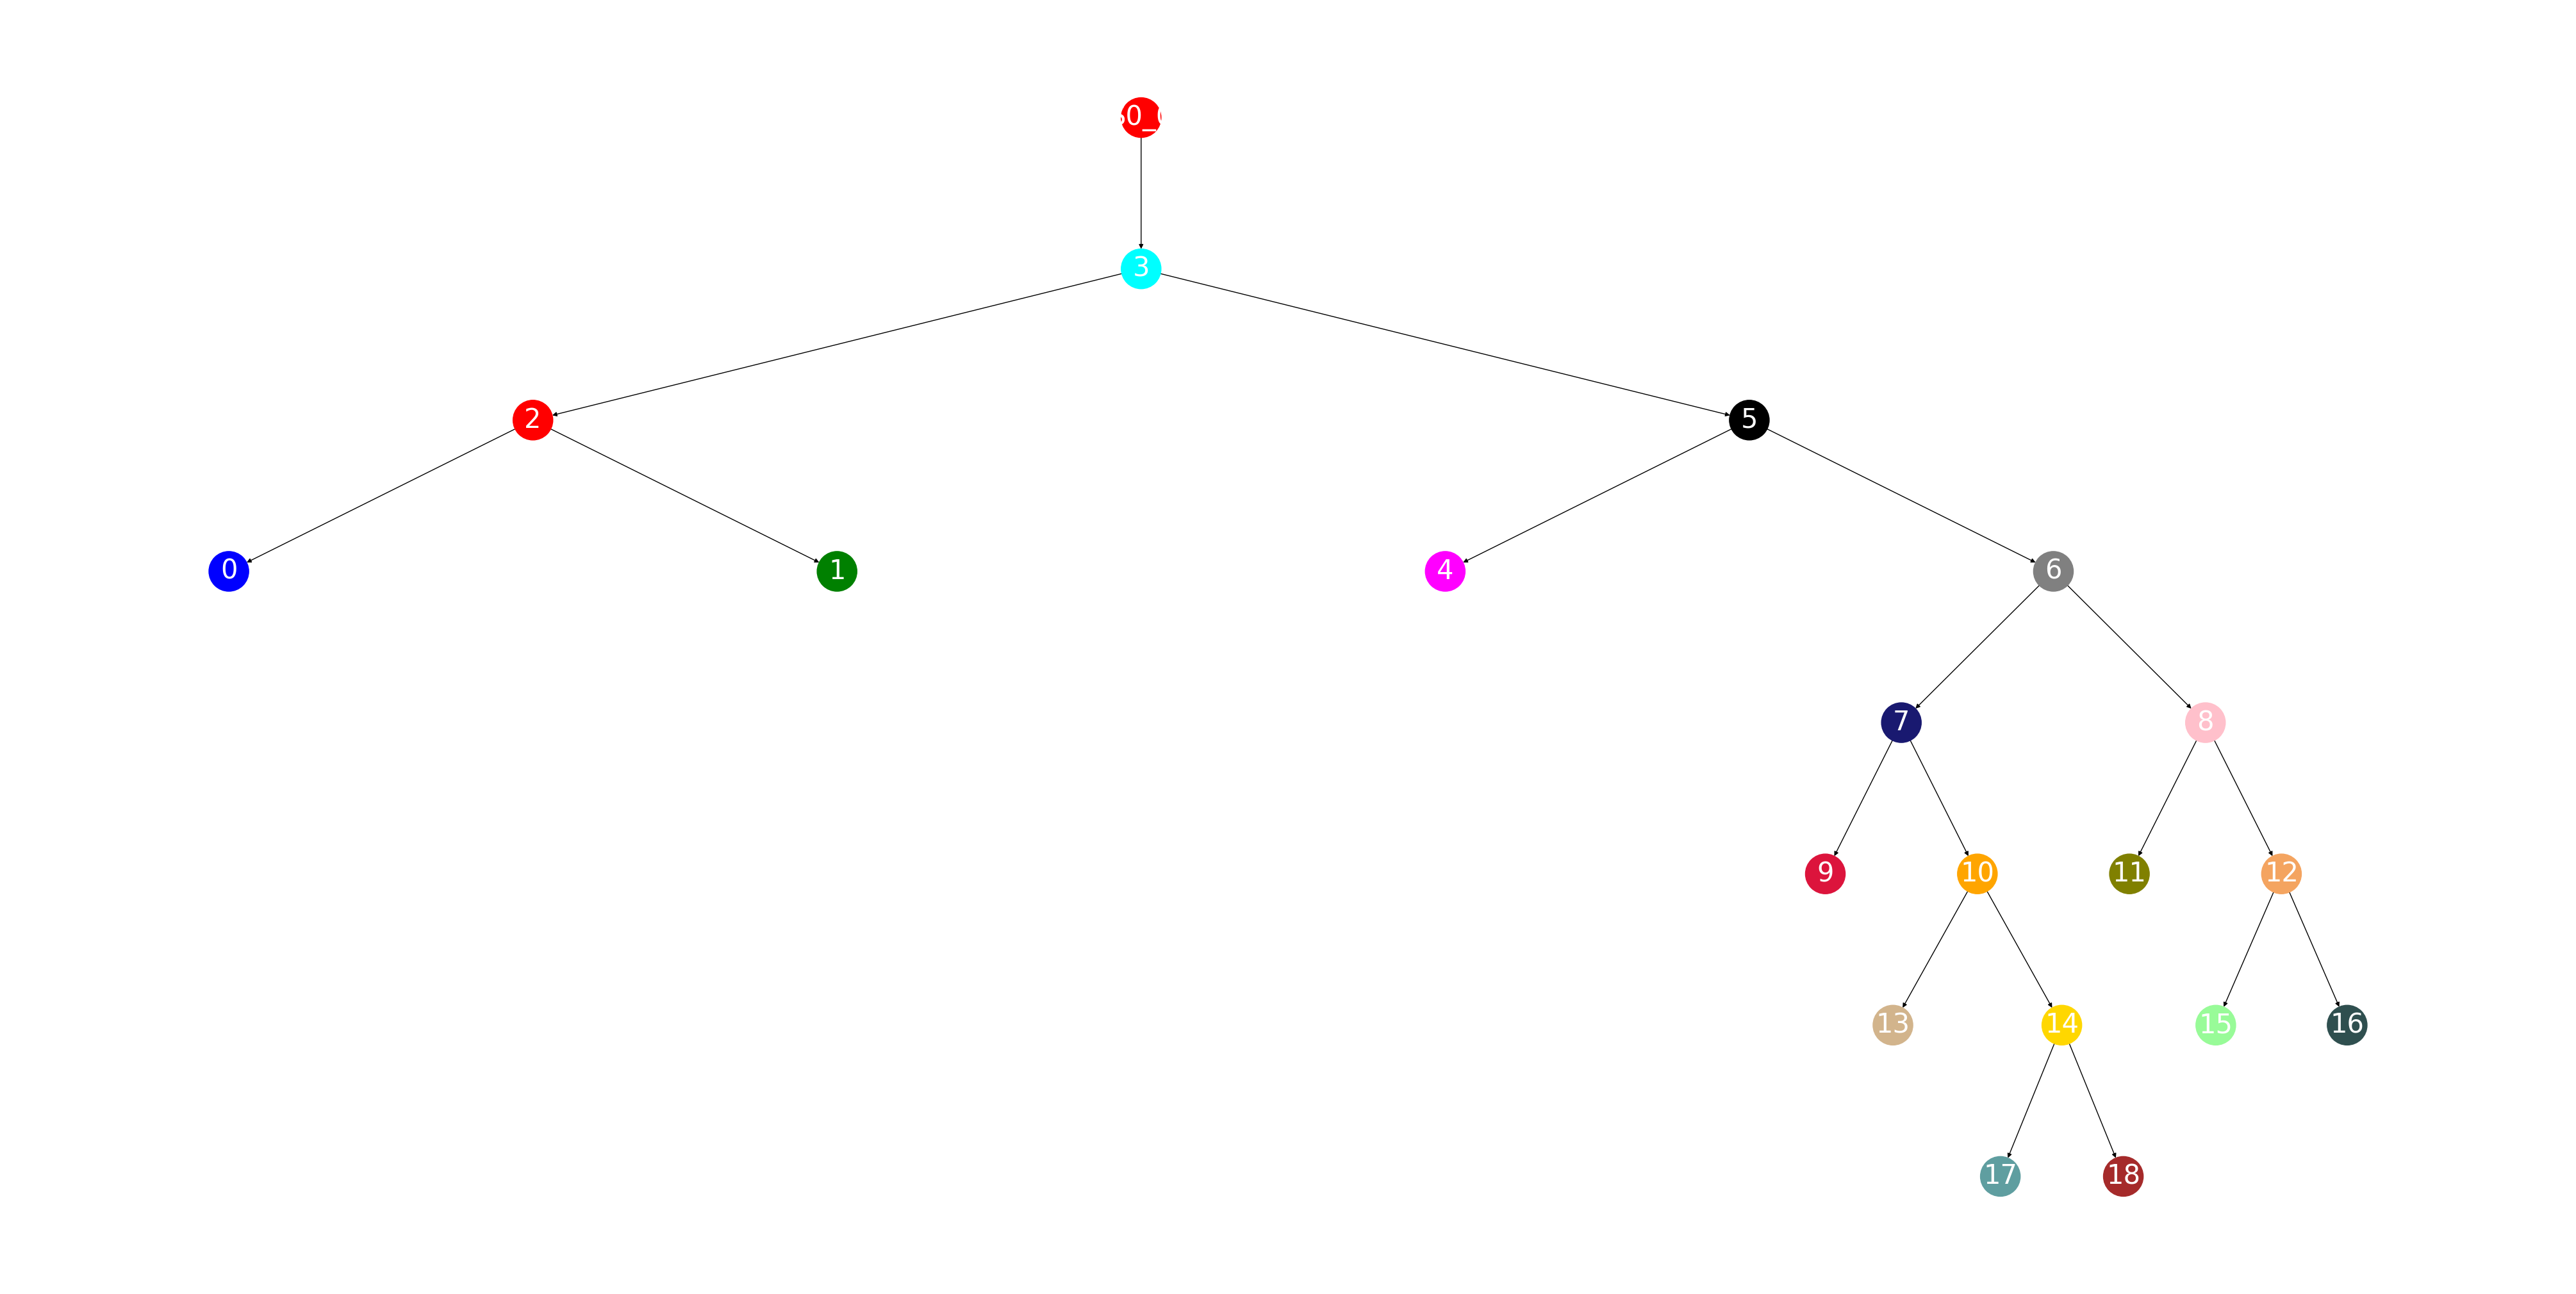

In [26]:
nviz.plot_limb(neuron_obj_rec,0)

In [27]:
branch_idx = 3
limb_idx = 0

branch_mesh = neuron_obj_rec[limb_idx][branch_idx].mesh
ipvu.plot_objects(branch_mesh)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [28]:
_ = branch_mesh.export(f"{segment_id}_limb_{limb_idx}_branch_{branch_idx}.off")

# Step 4A: Multi Soma Split Suggestions

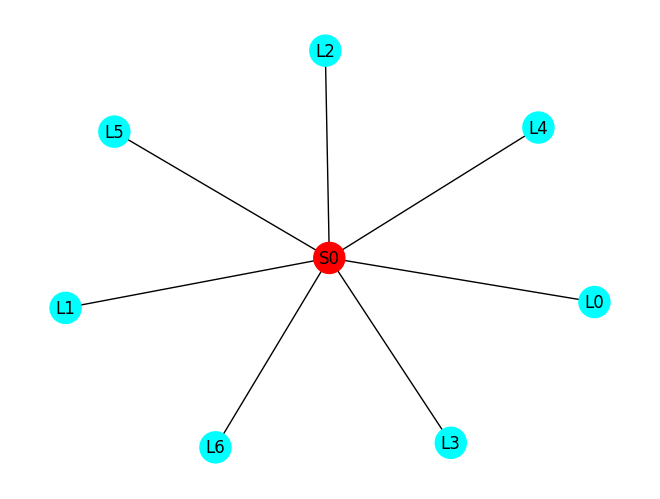

In [29]:
from neurd import neuron_visualizations as nviz
nviz.plot_soma_limb_concept_network(
    neuron_obj
)

In [30]:
multi_soma_split_parameters = dict()

In [31]:
_ = neuron_obj.calculate_multi_soma_split_suggestions(
    plot = True,
    store_in_obj = True,
    **multi_soma_split_parameters
)


In [32]:
neuron_obj.pipeline_products.multi_soma_split_suggestions.multi_soma_split_parameters = multi_soma_split_parameters

# Step 4B: Multi Soma Split Execution

In [33]:
neuron_list = neuron_obj.multi_soma_split_execution(
    verbose = False,
)

No error limbs to processs so just returning the original neuron


In [34]:
n1 = neuron_list[0]
print(n1.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':32414,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(54, 3), faces.shape=(18, 3))>, <trimesh.Trimesh(vertices.shape=(4, 3), faces.shape=(2, 3))>, <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>, <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>],
    'soma_extraction_parameters':
    {
    },
    'soma_meshes':[<trimesh.Trimesh(vertices.shape=(40159, 3), faces.shape=(79672, 3))>],
    'soma_run_time':72.30012321472168,
    'soma_sdfs':array([0.808672]),
  },
  'decomposition':
  {
    'bbox_volume':1.1508593103890605,
    'bbox_x_max':1285730.0,
    'bbox_x_max_soma_relative':65163.36356420722,
    'bbox_x_min':1191290.0,
    'bbox_x_min_soma_relative':-29276.63643579278,
    'bbox_y_max':1293642.4680380581,
    'bbox_y_max_soma_relative':76223.39815334976,
    'bbox_y_min':1191350.0,
    

# Step 5: Cell Typing

In [35]:
from neurd import neuron_pipeline_utils as npu

In [36]:
neuron_obj_axon = npu.cell_type_ax_dendr_stage(
    n1,
    mesh_decimated = mesh_decimated,
    plot_axon = False,
)

Exception: No synapse filepath set

In [ ]:
nviz.plot_axon(
    neuron_obj_axon
)

# Autoproofreading Stage

In [ ]:
neuron_obj_proof = npu.auto_proof_stage(
    neuron_obj_axon,
    mesh_decimated = mesh_decimated,
    calculate_after_proof_stats = False,
)

In [ ]:
_ = npu.after_auto_proof_stats(
    neuron_obj_proof,
    store_in_obj = True,
)

# Saving off the autoproofread neuron

In [ ]:
vdi.save_neuron_obj_auto_proof(
    neuron_obj_proof,
)

# Plotting the final neuron

In [99]:
from neurd import synapse_utils as syu

In [100]:
from datasci_tools import ipyvolume_utils as ipvu
ipvu.plot_objects(
    neuron_obj_axon.mesh,
    meshes = [neuron_obj_proof.mesh],
    meshes_colors="red"
)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [101]:
syu.plot_synapses(neuron_obj_proof)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [102]:
syu.plot_synapses_error_from_neuron_obj(neuron_obj_proof)    

# of error synapses = 199

 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [103]:
syu.plot_synapses_valid_from_neuron_obj(neuron_obj_proof)  

# of valid synapses = 2116

 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [104]:
nviz.plot_compartments(neuron_obj_proof)


 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

apical:blue
apical_shaft:aqua
apical_tuft:purple
basal:yellow
axon:red
oblique:green


Unlabeled: transparent green


In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
